# Notebook para testar a classificacao por clusters

In [208]:
import sys
import os
import pandas as pd
import numpy as np
import seaborn as sns
from itertools import combinations
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
import matplotlib.pyplot as plt

import yara
import yara_tools

In [209]:
TRAIN_DIR = '/archive/files/nastyware-files-mix/mix-import/'
TEST_MALWARE_DIR = '/archive/files/nastyware-files/import-malware-bazaar-2021-01-to-2021-02/'
TEST_GOODWARE_DIR = '/archive/files/nastyware-files/import-windows-server-2016/'

In [210]:
# !./pe-analyser.py --folder $TRAIN_DIR

In [211]:
node_clustering_fn = 'node_clustering_fastgreedy.txt'

lines = open(node_clustering_fn, 'r').readlines()
lines = lines[1:]

clusters = [[el.strip() for el in line.strip().split(',') if not el.strip().startswith('-')] for line in lines]

In [212]:
EPSILON = 1

In [213]:
mostly_malware_clusters = []

for cluster in clusters:
    if len(cluster) > 1:
        malware_count = 0
        for node in cluster:
            if node.startswith('R-'):
                malware_count += 1

        # Verificar a frequencia com que sera adicionado no cluster
        if malware_count >= EPSILON * len(cluster):
            mostly_malware_clusters.append(cluster)

# mostly_malware_clusters

---

## Primeiro teste - Decision Tree

### Treinando o classificador

In [214]:
func_dict = {}

In [215]:
def ld_data(dir_name, files, label=None):
    # Load data in files from directory dir_name in a pandas dataframe
    df = pd.DataFrame()
    for filename in files:
        funcs = []
        with open(os.path.join(dir_name, filename), 'r') as f:
            lines = f.read().splitlines()
            
            for line in lines:
                lib, func = line.split(' ')
                if '@' in func or '?' in func:
                    continue

                if not func.lower() in func_dict:
                    func_dict[func.lower()] = [(lib, func)]
                else:
                    func_dict[func.lower()].append((lib, func))

                funcs.append(func)

        # label = 'MALWARE' if filename.startswith('R') else 'GOODWARE'
        df = pd.concat([df, pd.DataFrame({'filename': filename, 'label': label, 'funcs': ' '.join(funcs)}, index=[0])], ignore_index=True)
        
    return df

In [216]:
malware_clusters_df = [ld_data(TRAIN_DIR, cluster, str(i)) for i, cluster in enumerate(mostly_malware_clusters)]
rest_df = ld_data(TRAIN_DIR, [f for f in os.listdir(TRAIN_DIR) if not any([f in cluster for cluster in mostly_malware_clusters])], '-1')

# Concat in rest_df all malware_clusters_df
df = pd.concat([rest_df] + malware_clusters_df, ignore_index=True)

In [217]:
df

,filename,label,funcs
0,G-sbscmp20_perfcounter.dll,-1,_except_handler4_common _initterm malloc free ...
1,R-cd924904ae0e1d03b5928ebf1a16fe7b4ef07ac37448...,-1,VarBstrFromI4 CryptVerifyMessageSignature Cert...
2,G-InternetMailCsp.dll,-1,wcscpy_s memset realloc _XcptFilter _amsg_exit...
3,G-Windows.System.Diagnostics.dll,-1,__dllonexit _onexit free _XcptFilter _except_h...
4,G-instnm.exe,-1,_except_handler4_common _controlfp _initterm _...
...,...,...,...
132,R-1a13b0a4251771ac84bff5b2009e1fbd8eb2c8fdbd12...,13,GetModuleHandleW OutputDebugStringA LoadLibrar...
133,R-fdf50dbb288d2bd4a325783e72c1e5c598c87ed11725...,13,RegSaveKeyExA AccessCheckAndAuditAlarmA SetWai...
134,R-d3e4a34d13bbfccea5715e95b34c4b2a61b9c9207528...,13,OutputDebugStringA LoadLibraryExA LoadLibraryA...
135,R-760475700ce0a3716da05885035916ca9a6f4931475b...,14,VarBstrFromI4 CryptVerifyMessageSignature Cert...


In [218]:
# Mudar isso para um BAG OF WORDS
vectorizer = TfidfVectorizer()
df_vectors = vectorizer.fit_transform(df['funcs']).ceil()

classifier = DecisionTreeClassifier(criterion='entropy')
classifier.fit(df_vectors, df['label'])

DecisionTreeClassifier(criterion='entropy')

/home/joao/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


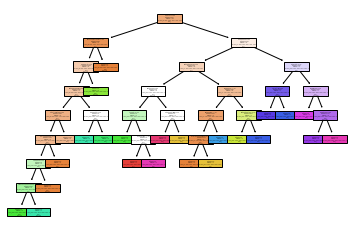

In [219]:
fn = vectorizer.get_feature_names()
cn = df['label'].unique()

plot_tree(classifier,
               feature_names = fn,
               class_names=cn,
               filled = True);

plt.savefig('asdf.svg')

### Testando o classificador

In [220]:
test_mw = ld_data(TEST_MALWARE_DIR, os.listdir(TEST_MALWARE_DIR), 'MALWARE')
test_gw = ld_data(TEST_GOODWARE_DIR, os.listdir(TEST_GOODWARE_DIR), 'GOODWARE')

test_df = pd.concat([test_mw, test_gw], ignore_index=True)

In [221]:
test_mw_vectors = vectorizer.transform(test_mw['funcs']).ceil()
test_gw_vectors = vectorizer.transform(test_gw['funcs']).ceil()
test_vectors = vectorizer.transform(test_df['funcs']).ceil()

pred_mw = classifier.predict(test_mw_vectors)
pred_gw = classifier.predict(test_gw_vectors)
pred = classifier.predict(test_vectors)

pred_mw = ['MALWARE' if p != '-1' else 'GOODWARE' for p in pred_mw]
pred_gw = ['MALWARE' if p != '-1' else 'GOODWARE' for p in pred_gw]
pred = ['MALWARE' if p != '-1' else 'GOODWARE' for p in pred]

In [222]:
print('Accuracy total: {}'.format(accuracy_score(test_df['label'], pred)))
print('Accuracy malware: {}'.format(accuracy_score(test_mw['label'], pred_mw)))
print('Accuracy goodware: {}'.format(accuracy_score(test_gw['label'], pred_gw)))
print('F1 score: {}'.format(f1_score(test_df['label'], pred, average='weighted')))

Accuracy total: 0.6526050117180457
Accuracy malware: 0.8147873392680515
Accuracy goodware: 0.4992400327370513
F1 score: 0.6443388832571209


### Criando regras YARA

In [223]:
n_nodes = classifier.tree_.node_count
children_left = classifier.tree_.children_left
children_right = classifier.tree_.children_right
feature = classifier.tree_.feature
threshold = classifier.tree_.threshold
value = classifier.tree_.value
impurity = classifier.tree_.impurity

In [224]:
def find_path(node_numb, path, x):
    path.append(node_numb)
    if node_numb == x:
        return True
    left = False
    right = False
    if (children_left[node_numb] != -1):
        left = find_path(children_left[node_numb], path, x)
    if (children_right[node_numb] != -1):
        right = find_path(children_right[node_numb], path, x)
    if left or right:
        return True
    path.remove(node_numb)
    return False

def get_rule(path, column_names):
    mask = ''
    for index, node in enumerate(path):
        if index != len(path) - 1:
            if (children_left[node] == path[index+1]):
                mask += "(df['{}']<= {}) \t ".format(column_names[feature[node]], threshold[node])
            else:
                mask += "(df['{}']> {}) \t ".format(column_names[feature[node]], threshold[node])
    mask = mask.replace("\t", "&", mask.count("\t") - 1)
    mask = mask.replace("\t", "")
    return mask

def get_yara_rule(rule, condition_group, path, column_names):
    for index, node in enumerate(path):
        if index != len(path) - 1:
            func_lwr = column_names[feature[node]]
            if (children_left[node] == path[index+1]):
                rule.create_condition_group(name="{}_{}".format(condition_group, index), parent_group=condition_group, default_boolean="and")
                for lib, func in func_dict[func_lwr]:
                    rule.add_condition(f'not(pe.imports("{lib}", "{func}"))', condition_group="{}_{}".format(condition_group, index))
            else:
                rule.create_condition_group(name="{}_{}".format(condition_group, index), parent_group=condition_group, default_boolean="or")
                for lib, func in func_dict[func_lwr]:
                    rule.add_condition(f'pe.imports("{lib}", "{func}")', condition_group="{}_{}".format(condition_group, index))

In [225]:
file_content = ''

for i in range(len(df['label'].unique()) - 1):

    rule = yara_tools.create_rule(name=f"rule_cluster_{i}", default_boolean='or')

    rule.add_import(name="pe")

    # Leaves
    leave_id = classifier.apply(df_vectors)

    paths = {}
    for leaf in np.unique(leave_id):
        path_leaf = []
        find_path(0, path_leaf, leaf)
        paths[leaf] = np.unique(np.sort(path_leaf))

    # Cut paths that lead to goodwares
    filtered_paths = {}
    for path in paths:
        samples_count = value[path][0]
        goodware_value_index = 0
        malware_value_index = i + 1
        if samples_count[malware_value_index] > samples_count[goodware_value_index]:
            filtered_paths[path] = paths[path]

    paths = filtered_paths

    for leaf_num in paths:
        rule.create_condition_group(name="group_{}".format(leaf_num), default_boolean='and')
        get_yara_rule(rule, "group_{}".format(leaf_num), paths[leaf_num], vectorizer.get_feature_names_out())

        try:
            generated_rule = rule.build_rule(condition_groups=True)

            compiled_rule = yara.compile(source=generated_rule)

            file_content += str(generated_rule) + '\n'
        except:
            print('Error on rule {}'.format(rule.name))

file_content = file_content.replace("import \"pe\"", "")\
    .replace("rule ", " drvnskm_rule ")\
    .replace("\"", "'")\
    .replace("\t", "")\
    .replace("\n", "")

print(file_content)
with open('rules.yar', 'w') as f:
    f.write(file_content)

 drvnskm_rule rule_cluster_0{condition:((pe.imports('kernel32.dll', 'ExitProcess') or pe.imports('api-ms-win-core-processthreads-l1-1-2.dll', 'ExitProcess') or pe.imports('api-ms-win-core-processthreads-l1-1-1.dll', 'ExitProcess') or pe.imports('api-ms-win-core-processthreads-l1-1-0.dll', 'ExitProcess') or pe.imports('api-ms-win-downlevel-kernel32-l1-1-0.dll', 'ExitProcess')) and (not(pe.imports('user32.dll', 'DestroyWindow')) and not(pe.imports('ext-ms-win-rtcore-ntuser-window-ext-l1-1-0.dll', 'DestroyWindow')) and not(pe.imports('api-ms-win-rtcore-ntuser-window-l1-1-0.dll', 'DestroyWindow'))) and (not(pe.imports('kernel32.dll', 'GetCurrentProcessId')) and not(pe.imports('api-ms-win-core-processthreads-l1-1-2.dll', 'GetCurrentProcessId')) and not(pe.imports('api-ms-win-core-processthreads-l1-1-0.dll', 'GetCurrentProcessId')) and not(pe.imports('api-ms-win-core-processthreads-l1-1-1.dll', 'GetCurrentProcessId')) and not(pe.imports('api-ms-win-downlevel-kernel32-l1-1-0.dll', 'GetCurrent

---

## Segundo teste - Similaridades e diferencas

### Obtendo as similaridades e diferencas

In [61]:
# Functions that occur in all malwares in the cluster
def plus_functions(dir, cluster):
    file_sets = []

    for file in cluster:
        
        file_sets.append(set(line.split(' ')[1] for line in open(os.path.join(dir, file)).read().splitlines()))
        
        # Remove all the functions from set that has '@' or '?' in it
        file_sets[-1] = {func for func in file_sets[-1] if not ('@' in func or '?' in func)}
    

    intersection = set.intersection(*file_sets)

    return intersection


# Functions that does not occur in any malwares in the cluster
def minus_functions(dir, cluster):
    others_set = set()

    dir = os.path.join(dir)

    for file in os.listdir(dir):
        if file in cluster:
            continue

        others_set.update(set(line.split(' ')[1] for line in open(os.path.join(dir, file)).read().splitlines()))
    
    others_set = {func for func in others_set if not ('@' in func or '?' in func)}

    cluster_set = set()
    for file in cluster:
        cluster_set.update(set(line.split(' ')[1] for line in open(os.path.join(dir, file)).read().splitlines()))

    cluster_set = {func for func in cluster_set if not ('@' in func or '?' in func)}

    others_minus_cluster = others_set - cluster_set

    return others_minus_cluster

def functions(dir):
    return [set(line.split(' ')[1] for line in open(os.path.join(dir, file)).read().splitlines()) for file in os.listdir(dir)]

In [62]:

plus = [plus_functions(TRAIN_DIR, cluster) for cluster in mostly_malware_clusters]
minus = [minus_functions(TRAIN_DIR, cluster) for cluster in mostly_malware_clusters]

In [63]:
[len(p) for p in plus]

[46,
 2,
 3,
 18,
 42,
 15,
 35,
 29,
 66,
 51,
 74,
 58,
 70,
 51,
 39,
 76,
 159,
 159,
 8,
 47,
 167]

In [64]:
[len(m) for m in minus]

[4172,
 4196,
 4210,
 4277,
 4253,
 4210,
 4064,
 4178,
 4229,
 4131,
 4168,
 4181,
 4176,
 4030,
 3987,
 4042,
 4136,
 4136,
 3985,
 3275,
 3123]

In [65]:
def predict_similarity_difference(file_functions_set, plus_functions_set_list, minus_functions_set_list):

    for plus_functions_set, minus_functions_set in zip(plus_functions_set_list, minus_functions_set_list):
        plus_functions_intersection = file_functions_set & plus_functions_set
        minus_functions_intersection = file_functions_set & minus_functions_set

        if len(plus_functions_intersection) == len(plus_functions_set) and len(minus_functions_intersection) == 0:
            return 'MALWARE'

    return 'GOODWARE'


In [66]:
test_mw = functions(TEST_MALWARE_DIR)
test_gw = functions(TEST_GOODWARE_DIR)
test = test_mw + test_gw

test_mw_label = ['MALWARE' for _ in test_mw]
test_gw_label = ['GOODWARE' for _ in test_gw]
test_label = test_mw_label + test_gw_label

pred_mw = [predict_similarity_difference(file_functions_set, plus, minus) for file_functions_set in test_mw]
pred_gw = [predict_similarity_difference(file_functions_set, plus, minus) for file_functions_set in test_gw]
pred = [predict_similarity_difference(file_functions_set, plus, minus) for file_functions_set in test]

In [67]:
print('Accuracy total: {}'.format(accuracy_score(test_label, pred)))
print('Accuracy malware: {}'.format(accuracy_score(test_mw_label, pred_mw)))
print('Accuracy goodware: {}'.format(accuracy_score(test_gw_label, pred_gw)))
print('F1 score: {}'.format(f1_score(test_label, pred, average='weighted')))

Accuracy total: 0.5923321915750256
Accuracy malware: 0.16122650840751732
Accuracy goodware: 1.0
F1 score: 0.5029818691540772


### Criando reegras YARA

In [68]:
"""
if len(plus) != len(minus):
    raise ValueError("Plus and minus functions must be of the same length")

for i in range(len(plus)):
    rule = yara_tools.create_rule(name=f"rule_cluster_{i}")
    rule.add_import(name="pe")

    for func_lwr in plus[i]:
        func_lwr = func_lwr.lower()
        rule.create_condition_group(name="group_{}".format(func_lwr), default_boolean='or')
        for lib, func in func_dict[func_lwr]:
            rule.add_condition(f'pe.imports("{lib}", "{func}")', condition_group="group_{}".format(func_lwr))

    for func_lwr in minus[i]:
        func_lwr = func_lwr.lower()
        rule.create_condition_group(name="group_{}".format(func_lwr), default_boolean='and')
        for lib, func in func_dict[func_lwr]:
            rule.add_condition(f'not(pe.imports("{lib}", "{func}"))', condition_group="group_{}".format(func_lwr))

    # generated_rule = rule.build_rule(condition_groups=True)

    # compiled_rule = yara.compile(source=generated_rule)

    # print (generated_rule)
"""

'\nif len(plus) != len(minus):\n    raise ValueError("Plus and minus functions must be of the same length")\n\nfor i in range(len(plus)):\n    rule = yara_tools.create_rule(name=f"rule_cluster_{i}")\n    rule.add_import(name="pe")\n\n    for func_lwr in plus[i]:\n        func_lwr = func_lwr.lower()\n        rule.create_condition_group(name="group_{}".format(func_lwr), default_boolean=\'or\')\n        for lib, func in func_dict[func_lwr]:\n            rule.add_condition(f\'pe.imports("{lib}", "{func}")\', condition_group="group_{}".format(func_lwr))\n\n    for func_lwr in minus[i]:\n        func_lwr = func_lwr.lower()\n        rule.create_condition_group(name="group_{}".format(func_lwr), default_boolean=\'and\')\n        for lib, func in func_dict[func_lwr]:\n            rule.add_condition(f\'not(pe.imports("{lib}", "{func}"))\', condition_group="group_{}".format(func_lwr))\n\n    # generated_rule = rule.build_rule(condition_groups=True)\n\n    # compiled_rule = yara.compile(source=gene